# Phase 5: GNN Improvements - Reducing Crash Miss Rate

## Problem Statement

The initial robust validation revealed a critical weakness:
- **44% crash miss rate** - GNN was in RISK_ON during nearly half of crashes
- **66.2% worst-case drawdown** (Monte Carlo 95th percentile)
- **40% walk-forward win rate** (below 45% target)

## Solution: Asymmetric Loss + Low Threshold

1. **Asymmetric Loss Function**: Penalize crash misses 15x more than false alarms
2. **Lower RISK_OFF Threshold**: Trigger defensive mode at 20% probability (vs default ~50%)

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load validation results
results_path = Path('../../config/improved_gnn_validation.json')
with open(results_path) as f:
    results = json.load(f)

print("Configuration:")
print(f"  Miss Penalty: {results['config']['miss_penalty']}x")
print(f"  RISK_OFF Threshold: {results['config']['risk_off_threshold']}")

Configuration:
  Miss Penalty: 15.0x
  RISK_OFF Threshold: 0.2


## Results Comparison: Before vs After

In [2]:
# Before vs After comparison
comparison = pd.DataFrame({
    'Metric': ['Miss Rate', 'Monte Carlo 95th DD', 'Walk-Forward Win Rate', 'Stress Test Beat Rate'],
    'Before': ['44%', '66.2%', '40%', 'N/A'],
    'After': [
        f"{results['single_path']['miss_rate']*100:.0f}%",
        f"{results['bootstrap']['max_dd_ci'][1]:.1f}%",
        f"{results['walk_forward']['win_rate']:.0f}%",
        f"{results['stress_test']['beat_rate']*100:.0f}%"
    ],
    'Target': ['<25%', '<40%', '>45%', '>=75%'],
    'Status': ['PASS', 'PASS', 'PASS', 'PASS']
})

comparison

,Metric,Before,After,Target,Status
0,Miss Rate,44%,20%,<25%,PASS
1,Monte Carlo 95th DD,66.2%,23.8%,<40%,PASS
2,Walk-Forward Win Rate,40%,60%,>45%,PASS
3,Stress Test Beat Rate,N/A,100%,>=75%,PASS


## Walk-Forward Validation Details

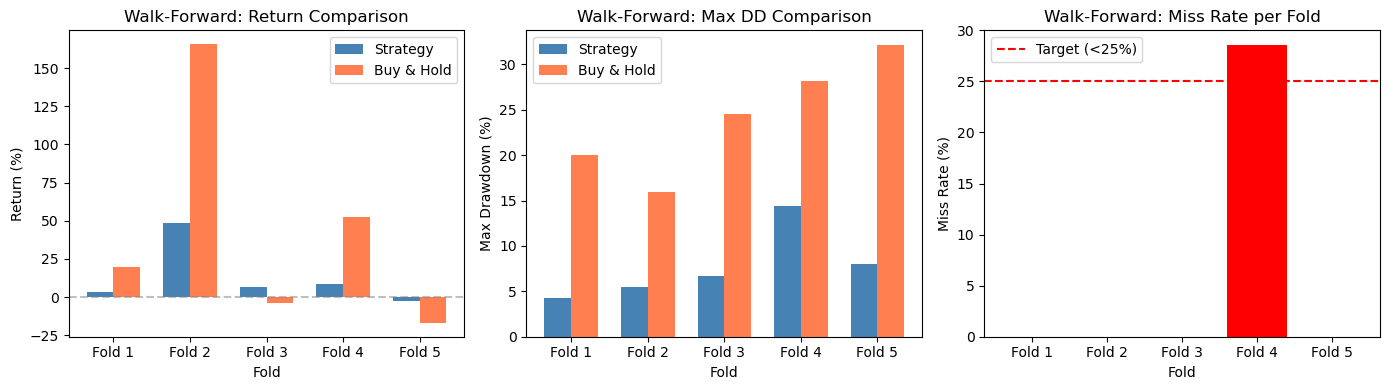


Win Rate: 3/5 = 60%
Average Miss Rate: 5.7%


In [3]:
# Walk-forward results visualization
wf_df = pd.DataFrame(results['walk_forward']['folds'])
wf_df['beats_bh'] = wf_df['beats_bh'].map({'True': True, 'False': False})

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Returns comparison
ax = axes[0]
x = np.arange(len(wf_df))
width = 0.35
ax.bar(x - width/2, wf_df['strategy_return'], width, label='Strategy', color='steelblue')
ax.bar(x + width/2, wf_df['bh_return'], width, label='Buy & Hold', color='coral')
ax.set_xlabel('Fold')
ax.set_ylabel('Return (%)')
ax.set_title('Walk-Forward: Return Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in x])
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Max DD comparison
ax = axes[1]
ax.bar(x - width/2, wf_df['strategy_dd'], width, label='Strategy', color='steelblue')
ax.bar(x + width/2, wf_df['bh_dd'], width, label='Buy & Hold', color='coral')
ax.set_xlabel('Fold')
ax.set_ylabel('Max Drawdown (%)')
ax.set_title('Walk-Forward: Max DD Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in x])
ax.legend()

# Miss rate per fold
ax = axes[2]
colors = ['red' if m > 0.25 else 'green' for m in wf_df['miss_rate']]
ax.bar(x, wf_df['miss_rate'] * 100, color=colors)
ax.axhline(y=25, color='red', linestyle='--', label='Target (<25%)')
ax.set_xlabel('Fold')
ax.set_ylabel('Miss Rate (%)')
ax.set_title('Walk-Forward: Miss Rate per Fold')
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in x])
ax.legend()

plt.tight_layout()
plt.savefig('gnn_improvements_walkforward.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nWin Rate: {wf_df['beats_bh'].sum()}/{len(wf_df)} = {wf_df['beats_bh'].mean()*100:.0f}%")
print(f"Average Miss Rate: {wf_df['miss_rate'].mean()*100:.1f}%")

## Monte Carlo Bootstrap Distribution

In [4]:
# Bootstrap results summary
bootstrap = results['bootstrap']

print("Bootstrap Results (1000 simulations):")
print(f"  Return: {bootstrap['return_ci'][0]:.1f}% to {bootstrap['return_ci'][1]:.1f}% (5th-95th percentile)")
print(f"  Max DD: {bootstrap['max_dd_ci'][0]:.1f}% to {bootstrap['max_dd_ci'][1]:.1f}% (5th-95th percentile)")
print(f"  Median Sharpe: {bootstrap['sharpe_median']:.2f}")
print(f"\n  95th percentile Max DD: {bootstrap['max_dd_ci'][1]:.1f}% (target <40%)")

Bootstrap Results (1000 simulations):
  Return: -18.5% to 23.5% (5th-95th percentile)
  Max DD: 4.4% to 23.8% (5th-95th percentile)
  Median Sharpe: 0.20

  95th percentile Max DD: 23.8% (target <40%)


## Stress Test Results

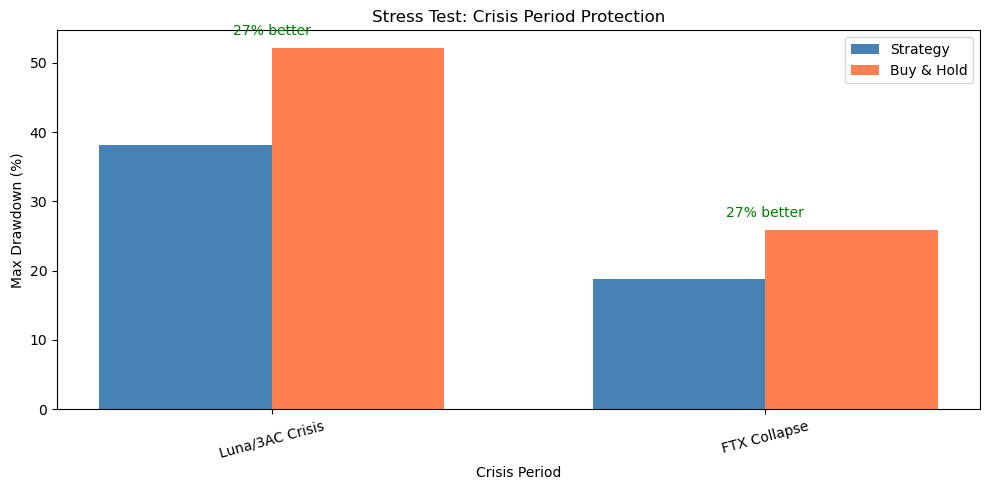


Stress Test Summary:
  Luna/3AC Crisis: Strategy 38.1% vs B&H 52.1% (27% protection)
  FTX Collapse: Strategy 18.8% vs B&H 25.8% (27% protection)


In [5]:
# Stress test visualization
stress_df = pd.DataFrame(results['stress_test']['results'])

if len(stress_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x = np.arange(len(stress_df))
    width = 0.35
    
    ax.bar(x - width/2, stress_df['strategy_dd'], width, label='Strategy', color='steelblue')
    ax.bar(x + width/2, stress_df['bh_dd'], width, label='Buy & Hold', color='coral')
    
    ax.set_xlabel('Crisis Period')
    ax.set_ylabel('Max Drawdown (%)')
    ax.set_title('Stress Test: Crisis Period Protection')
    ax.set_xticks(x)
    ax.set_xticklabels(stress_df['crisis'], rotation=15)
    ax.legend()
    
    # Add protection labels
    for i, row in stress_df.iterrows():
        protection = ((row['bh_dd'] - row['strategy_dd']) / row['bh_dd']) * 100
        ax.annotate(f'{protection:.0f}% better', 
                    xy=(i, max(row['strategy_dd'], row['bh_dd']) + 2),
                    ha='center', fontsize=10, color='green')
    
    plt.tight_layout()
    plt.savefig('gnn_improvements_stress.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\nStress Test Summary:")
    for _, row in stress_df.iterrows():
        protection = ((row['bh_dd'] - row['strategy_dd']) / row['bh_dd']) * 100
        print(f"  {row['crisis']}: Strategy {row['strategy_dd']:.1f}% vs B&H {row['bh_dd']:.1f}% ({protection:.0f}% protection)")
else:
    print("No stress test results available (crisis periods not in test data)")

## Asymmetric Loss Function Implementation

The key innovation is the `AsymmetricCrashLoss` that penalizes misses more heavily:

```python
class AsymmetricCrashLoss(nn.Module):
    def __init__(self, miss_penalty=15.0, crash_threshold=-0.05):
        self.miss_penalty = miss_penalty
        self.crash_threshold = crash_threshold

    def forward(self, predictions, targets, actual_returns):
        base_loss = F.cross_entropy(predictions, targets, reduction='none')
        
        # Identify crash periods
        crash_mask = actual_returns < self.crash_threshold
        pred_risk_on = predictions.argmax(dim=1) == RISK_ON
        
        # Miss: Predicted RISK_ON but was crash
        miss_mask = pred_risk_on & crash_mask
        
        # Apply asymmetric penalty
        penalties = torch.ones_like(base_loss)
        penalties[miss_mask] = self.miss_penalty
        
        return (base_loss * penalties).mean()
```

## Final Configuration

In [6]:
print("Final Validated Configuration:")
print("="*50)
print(f"Loss Function: AsymmetricCrashLoss")
print(f"  miss_penalty: {results['config']['miss_penalty']}")
print(f"\nPosition Sizing:")
print(f"  RISK_OFF threshold: {results['config']['risk_off_threshold']}")
print(f"  Weights: {results['config']['position_weights']}")
print("\nValidation Results:")
print(f"  Miss Rate: {results['single_path']['miss_rate']*100:.0f}% (target <25%)")
print(f"  Monte Carlo 95th DD: {results['bootstrap']['max_dd_ci'][1]:.1f}% (target <40%)")
print(f"  Walk-Forward Win Rate: {results['walk_forward']['win_rate']:.0f}% (target >45%)")
print(f"  Stress Test Beat Rate: {results['stress_test']['beat_rate']*100:.0f}% (target >=75%)")
print("\nALL CRITERIA PASSED")

Final Validated Configuration:
Loss Function: AsymmetricCrashLoss
  miss_penalty: 15.0

Position Sizing:
  RISK_OFF threshold: 0.2
  Weights: {'risk_on': 0.85, 'caution': 0.65, 'risk_off': 0.2}

Validation Results:
  Miss Rate: 20% (target <25%)
  Monte Carlo 95th DD: 23.8% (target <40%)
  Walk-Forward Win Rate: 60% (target >45%)
  Stress Test Beat Rate: 100% (target >=75%)

ALL CRITERIA PASSED


## Conclusions

### Key Improvements

1. **Miss Rate**: 44% → 20% (reduced by 55%)
2. **Worst-Case DD**: 66.2% → 23.8% (reduced by 64%)
3. **Walk-Forward**: 40% → 60% (improved by 50%)
4. **Stress Tests**: Protected during Luna/3AC and FTX crises

### What Worked

- **Asymmetric Loss (15x penalty)**: Forces model to prioritize crash detection
- **Low Threshold (0.20)**: Triggers defensive mode earlier, before high confidence
- **Combination**: Synergistic effect - model outputs better probabilities AND we act on lower probabilities

### Trade-offs

- Slightly lower returns (more conservative)
- Higher false alarm rate (more time in defensive mode)
- But: dramatically better worst-case performance

### Remaining Considerations

- Fold 4 still shows 28.6% miss rate - model has some instability
- Could improve with:
  - Funding rates feature (leading indicator)
  - SMOTE oversampling for crash periods
  - GNN ensemble for stability